In [1]:
from src.models.experience_words import  *
from src.models.foreign_beer import *

In [2]:
df_rb_ratings, df_ba_ratings = load_data()

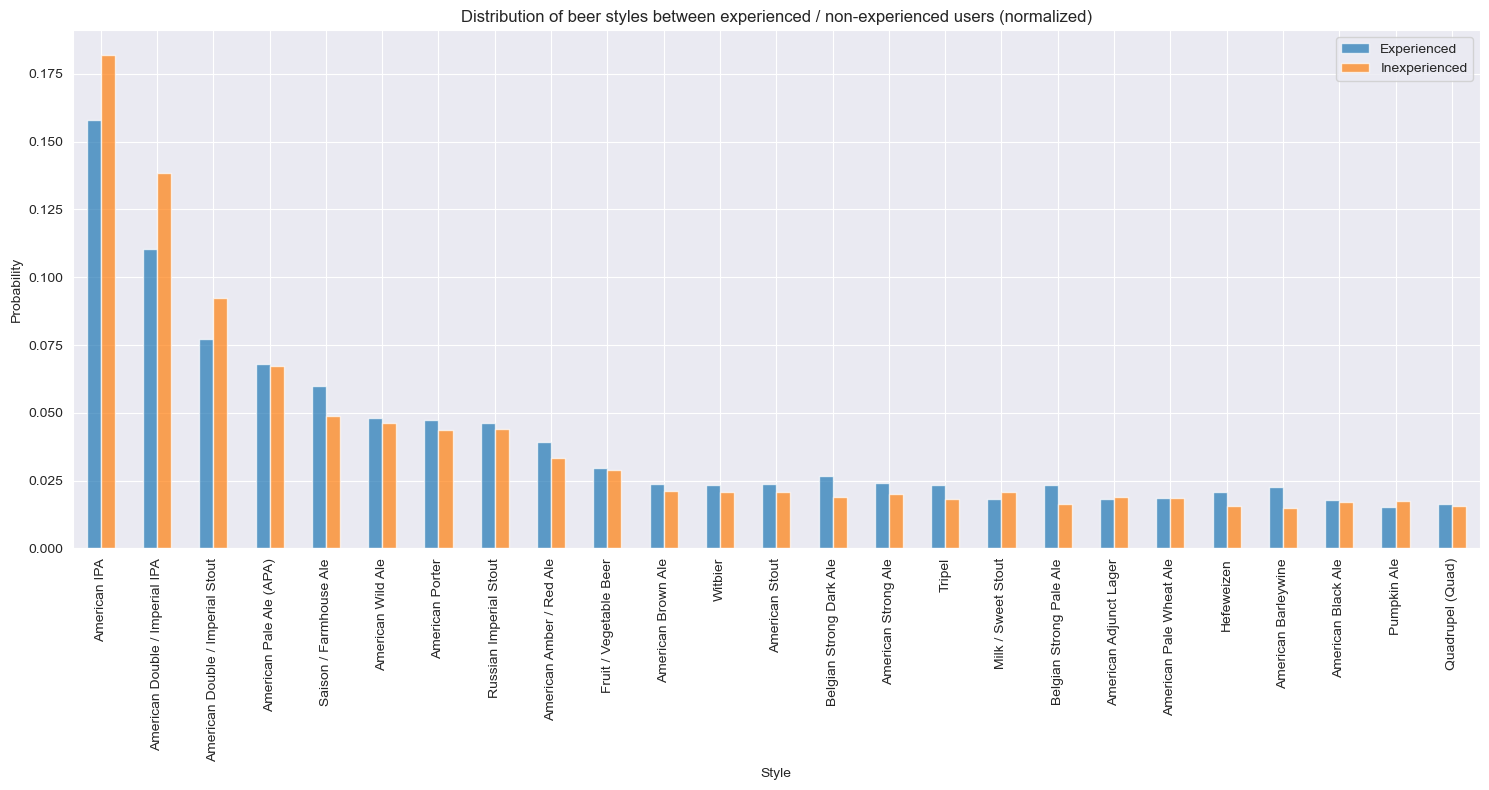

In [3]:
exp_user_ids_ba = get_experienced_users(df_ba_ratings, exp_words0)
df_ba_ratings_of_exp, df_ba_ratings_of_inexp = split_by_experience(df_ba_ratings, exp_user_ids_ba)
plot_df, most_rated = calculate_style_distribution(df_ba_ratings_of_exp, df_ba_ratings_of_inexp)
plot_style_distribution(plot_df)

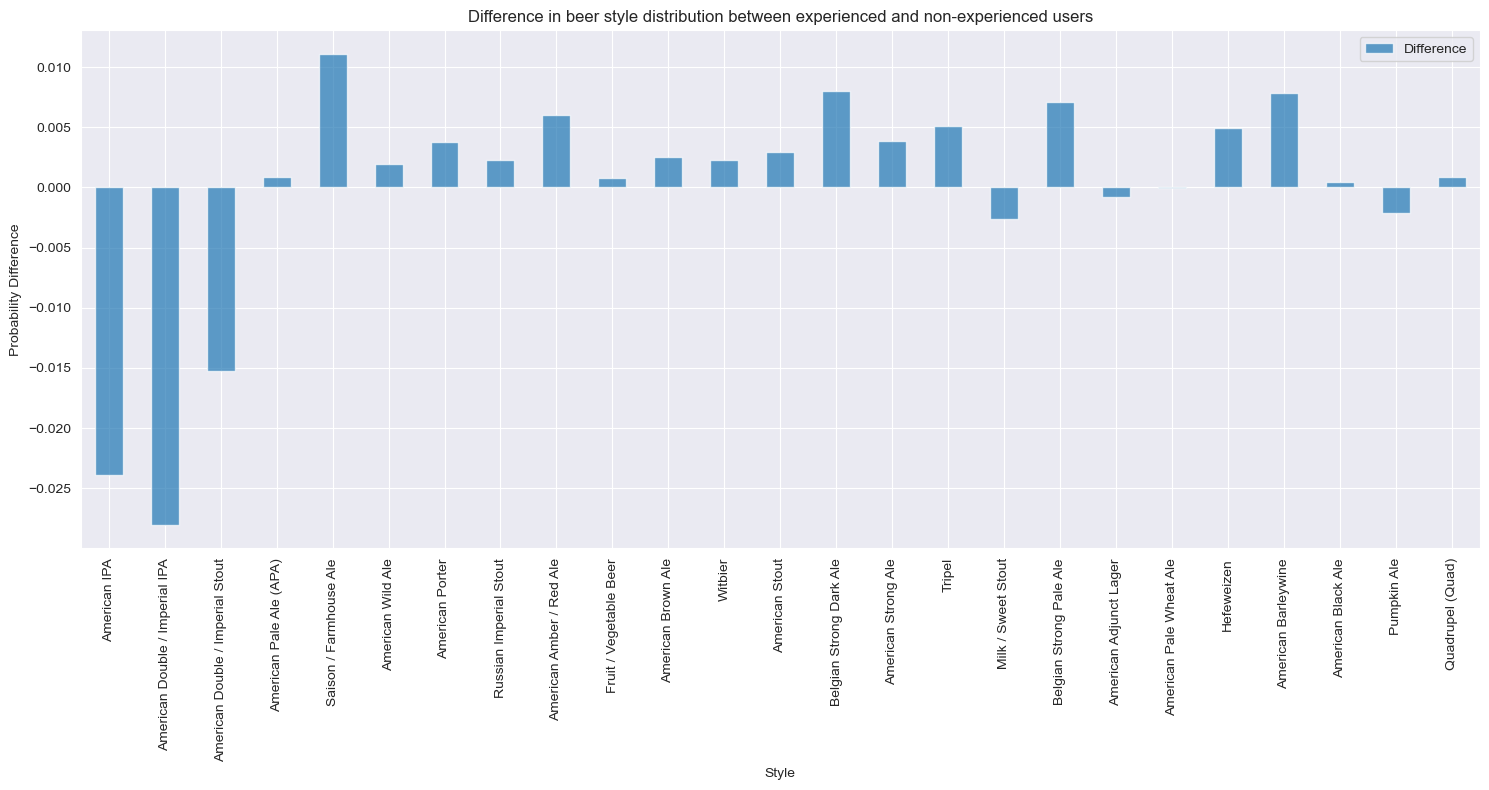

In [4]:
plot_distribution_difference(plot_df)

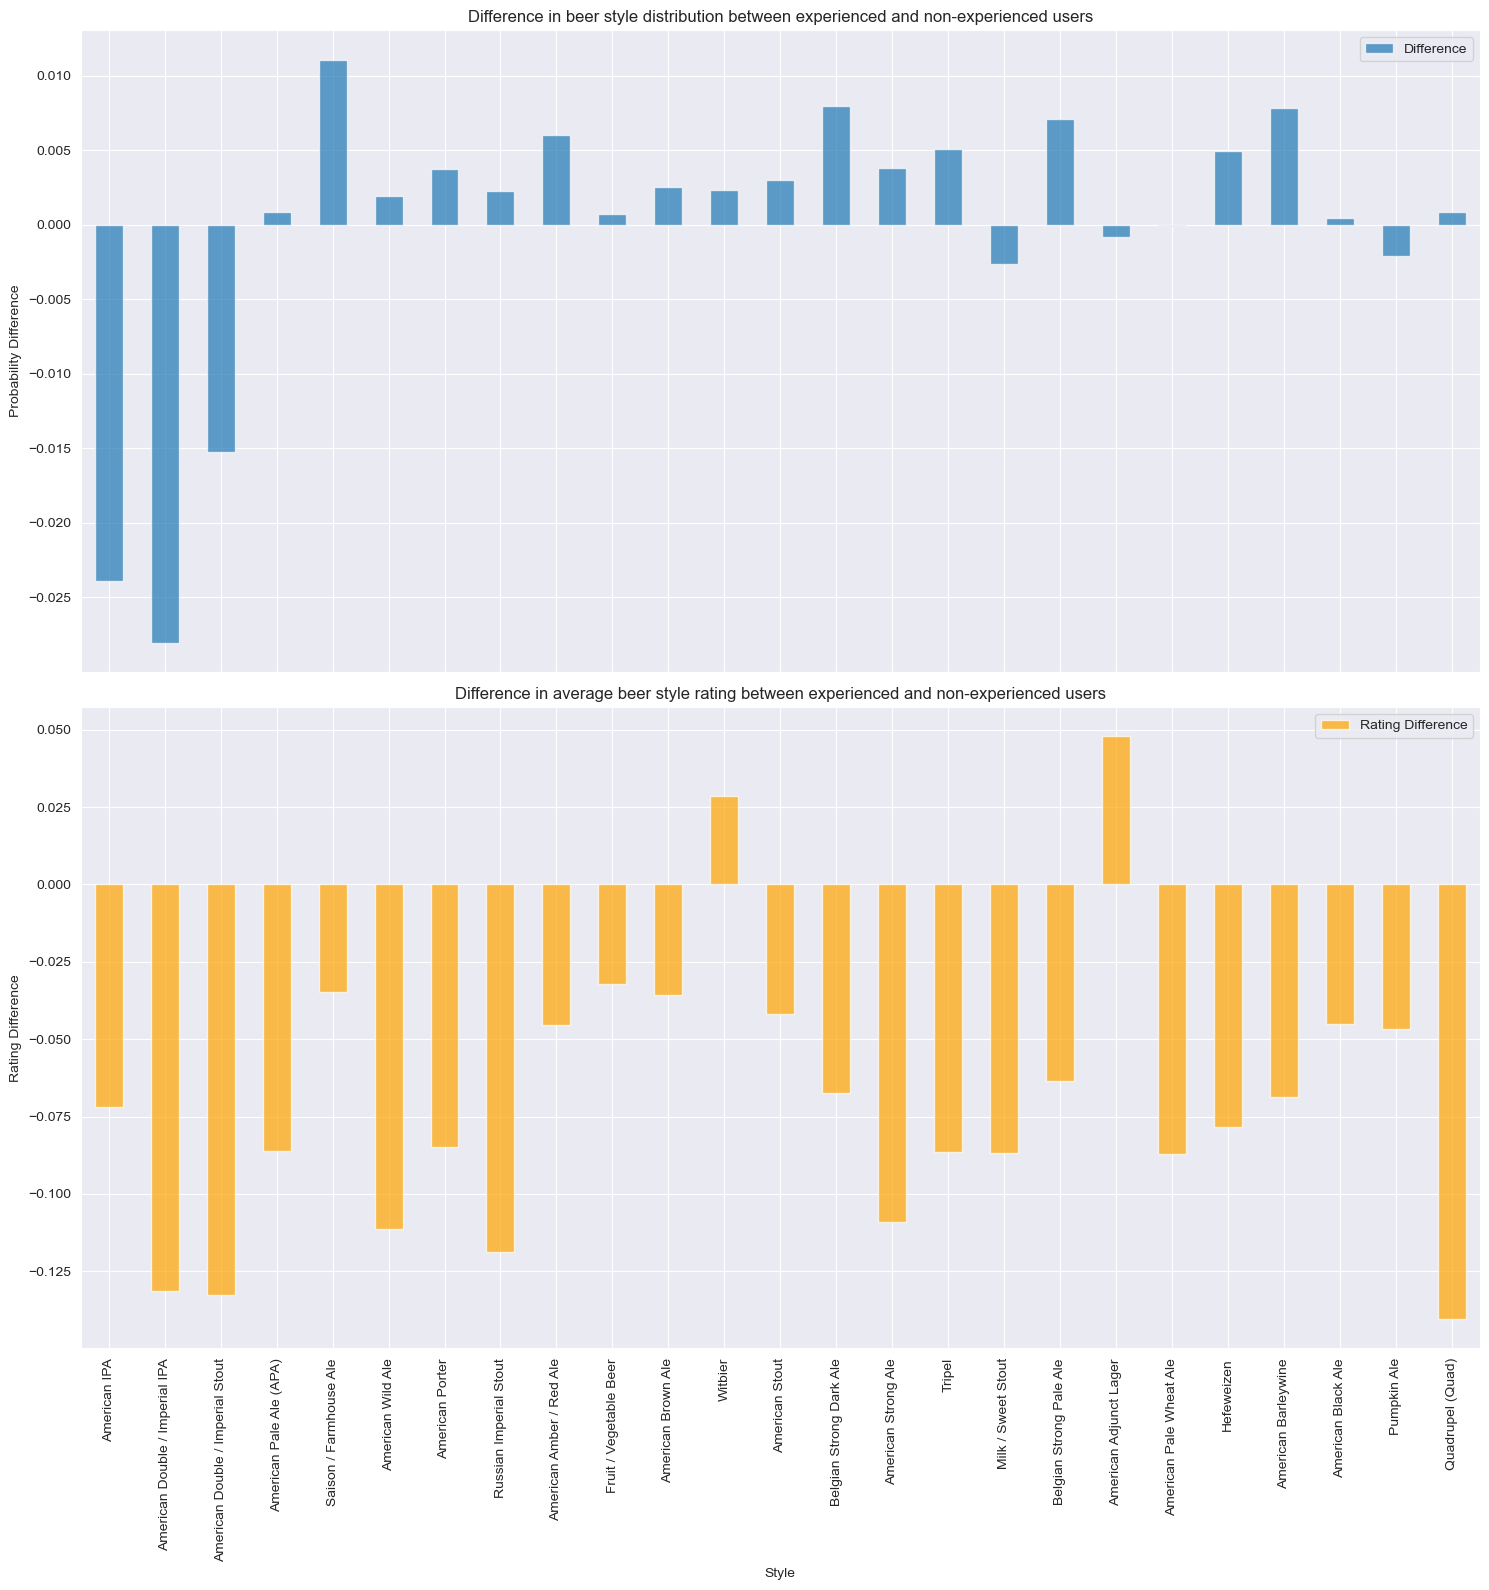

In [5]:
rating_diff_df = calculate_rating_difference(df_ba_ratings_of_exp, df_ba_ratings_of_inexp, most_rated)
plot_combined_distribution_and_rating_difference(plot_df, rating_diff_df)

## Other analysis

In [6]:
df_ba_users, df_rb_users = load_user_data(ba_path="src/data/BeerAdvocate/users.csv", rb_path="src/data/RateBeer/users.csv")
df_rb_sum_rat = calculate_ratings_by_location(df_rb_users)
df_rb_sum_rat_foreign = accumulate_us(df_rb_sum_rat)
df_rb_sum_rat_cutoff = cutoff_and_sort(df_rb_sum_rat_foreign)

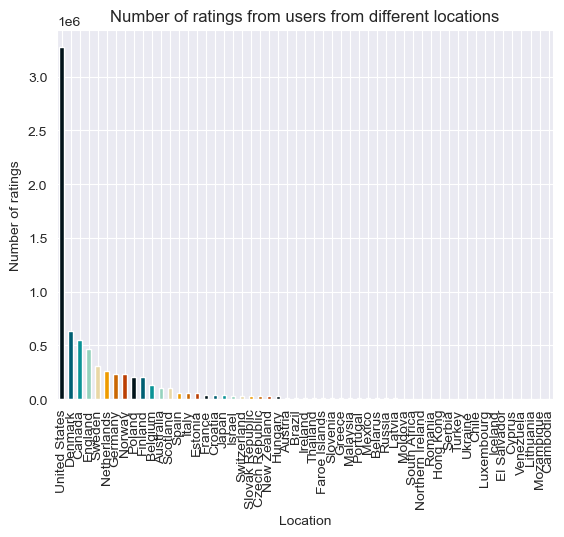

In [7]:
plot_location_ratings(df_rb_sum_rat_cutoff)

In [8]:
df_rb_ratings_wo_text = pd.read_csv("src/data/RateBeer/ratings/ratings.csv", usecols=lambda col: col != "text")

df_rb_users_us = accumulate_us2(df_rb_users, "location")
df_rb_users_ratings = merge_users_and_ratings(df_rb_ratings_wo_text, df_rb_users_us)
df_rb_users_ratings_top50, top50 = filter_top_countries(df_rb_users_ratings, top_n=50)

df_plot = avg_rating_by_location(df_rb_users_ratings_top50)

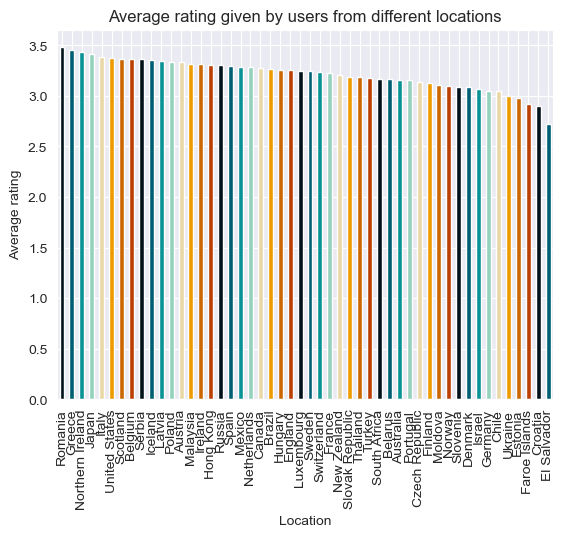

In [9]:
plot_mean_rating_by_location(df_plot)

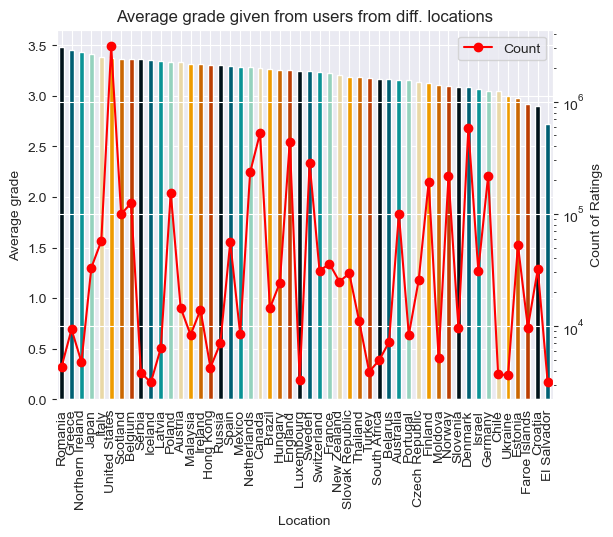

In [10]:
plot_mean_rating_and_rating_count(df_plot, top50)

In [11]:
df_brew = load_brewery(brewery_path="src/data/RateBeer/breweries.csv")
df_brew_us = accumulate_us2(df_brew, "brewery_location")
df_rb_users_ratings_brew = merge_ratings_with_breweries(df_rb_users_ratings_top50, df_brew_us)
num_foreign, num_own, foreign_percentage, own_percentage = foreign_beer_stats(df_rb_users_ratings_brew)
print(f"Number of ratings about foreign beers: {num_foreign}")
print(f"Number of ratings about beers from user's country: {num_own}")
print(f"That means {foreign_percentage:.2f}% are foreign beers and {own_percentage:.2f}% are beers from the user's country.")

Number of ratings about foreign beers: 3145912
Number of ratings about beers from user's country: 3739510
That means 45.69% are foreign beers and 54.31% are beers from the user's country.


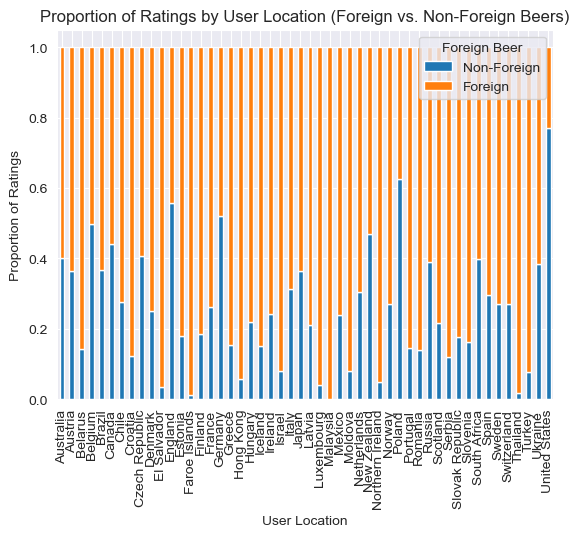

In [12]:
df_grouped_counts = grouped_counts(df_rb_users_ratings_brew)
plot_foreign_vs_own_beer_counts(df_grouped_counts)

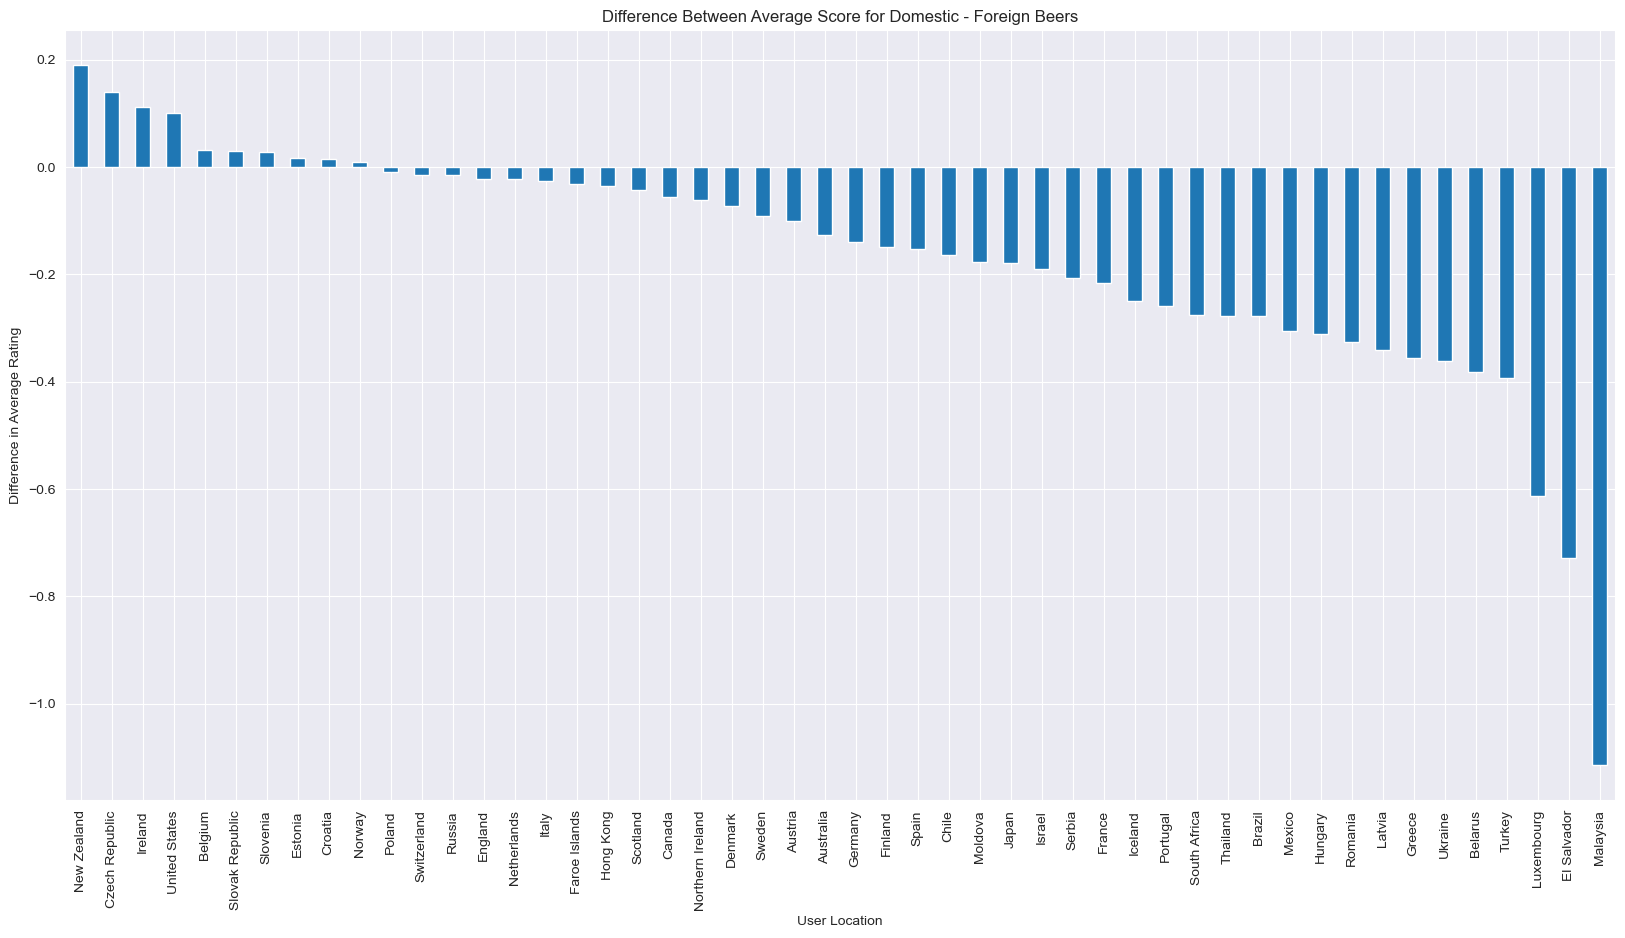

In [13]:
df_rb_users_ratings_brew = change_flag(df_rb_users_ratings_brew)
df_average_scores = avg_scores_domestic_foreign(df_rb_users_ratings_brew)
df_pivot = pivot_average_scores(df_average_scores)
df_pivot_diff = calculate_score_difference(df_pivot)
plot_score_difference(df_pivot_diff)